# Additional Gaussian_Mixture_Model

## Motivation

In the first notebook [core_jax_GMM](./core_jax_gaussian_mixture_model.ipynb), we initialized our initial clusters by "cheating" in that we used the unknowable true centers and adding noise. This worked
great as a teaching and sanity-checking tool, but in reality we can not know this. So, we initialize in many random locations and with a few cluster centers.

For this notebook, we take the concepts and code from our first notebook [core_jax_GMM](./core_jax_gaussian_mixture_model.ipynb) and expand on them. Some new concepts used:

- `RNG` for reproducible initializations of the mus and
- `PMAP` for parallelization of the GMM across the initializations

Before each newly introduced concept we briefly discuss the arguments and why the code is laid out the way it is :) 

In [1]:
# Import OS and specify the number of devices to force simulate BEFORE importing Jax
#   comment me out and run the next two lines to see what happens if we do not do this correctly
import os
os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=8"


In [2]:
import jax.numpy as jnp
import jax
import numpy as np  
np.random.seed(123)

from advanced_gmm import unknown_centers, make_ds, EM_GMM

In [3]:
jax.devices()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

## Create the function to be `pmap`-ed

We create a wrapping function that encompasses the logic of taking in a random seed for initializing the guessed centers

In [4]:
def run_gmm(rk, X, dims):
    main_key, subkey = rk
    # We can use the `main_key` for further random operations. The subkey should NOT be reused
    mus = jax.random.normal(subkey, shape=dims)

    sigmas = np.asarray([np.cov(X.T) for _ in range(K)])
    cls_probs = np.asarray([1 / K for _ in range(K)]).T
    cls_probs = np.expand_dims(cls_probs, axis=-1)
    return EM_GMM(
        X,
        mus=mus,
        sigmas=sigmas,
        cls_probs=cls_probs,
        guess_num_classes=K,
        verbose=False
    )

## Running the `pmap`



In [ ]:
parallel_gmm = jax.pmap(
    run_gmm, 
    
)

## Randomness

In [ ]:
from jax import random

seed = 42
init_key = random.key(seed)
keys_and_subkeys = random.split(init_key, len(jax.devices()))



# Run the parallel training

In [2]:
(X, y), _ = make_ds(unknown_centers)

N, M = X.shape

K = len(np.unique(y))
parallel_gmm()


jax.pmap(run_gmm)(, X)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Data Log-Likelihood at iteration: 0 = -447.838623
Data Log-Likelihood at iteration: 1 = -433.903900
Data Log-Likelihood at iteration: 2 = -423.097382
Data Log-Likelihood at iteration: 3 = -415.163666
Data Log-Likelihood at iteration: 4 = -411.345001
Data Log-Likelihood at iteration: 5 = -410.857086
Data Log-Likelihood at iteration: 6 = -410.450531
Data Log-Likelihood at iteration: 7 = -409.883301
Data Log-Likelihood at iteration: 8 = -409.062927
Data Log-Likelihood at iteration: 9 = -407.959015
Data Log-Likelihood at iteration: 10 = -406.774384
Data Log-Likelihood at iteration: 11 = -405.895721
Data Log-Likelihood at iteration: 12 = -405.427338
Data Log-Likelihood at iteration: 13 = -405.189056
Data Log-Likelihood at iteration: 14 = -405.035095
Data Log-Likelihood at iteration: 15 = -404.902313
Data Log-Likelihood at iteration: 16 = -404.764923
Data Log-Likelihood at iteration: 17 = -404.612457
Data Log-Likelihood at iteration: 18 = -404.443512
Data Log-Likelihood at iteration: 19 = -4

# Result Investigation

In [9]:
import matplotlib.pyplot as plt

## Plot the Log-likelihood

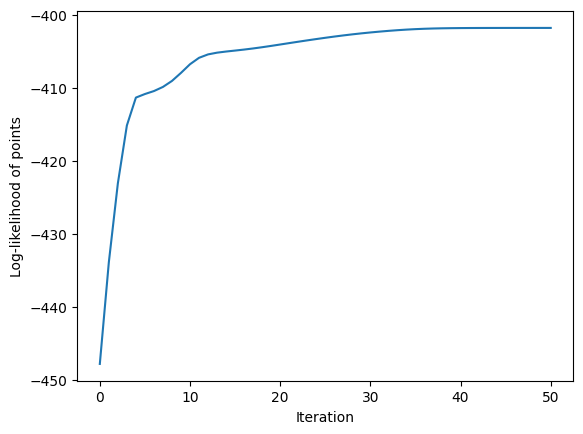

In [12]:
plt.plot(lls)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood of points")
plt.show()

# Show the Points

In [14]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(mu, sigma, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Modified based on function from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    pearson = sigma[0, 1]/np.sqrt(sigma[0, 0] * sigma[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(sigma[0, 0]) * n_std
    # calculating the standard deviation of y ...
    scale_y = np.sqrt(sigma[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mu[0], mu[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

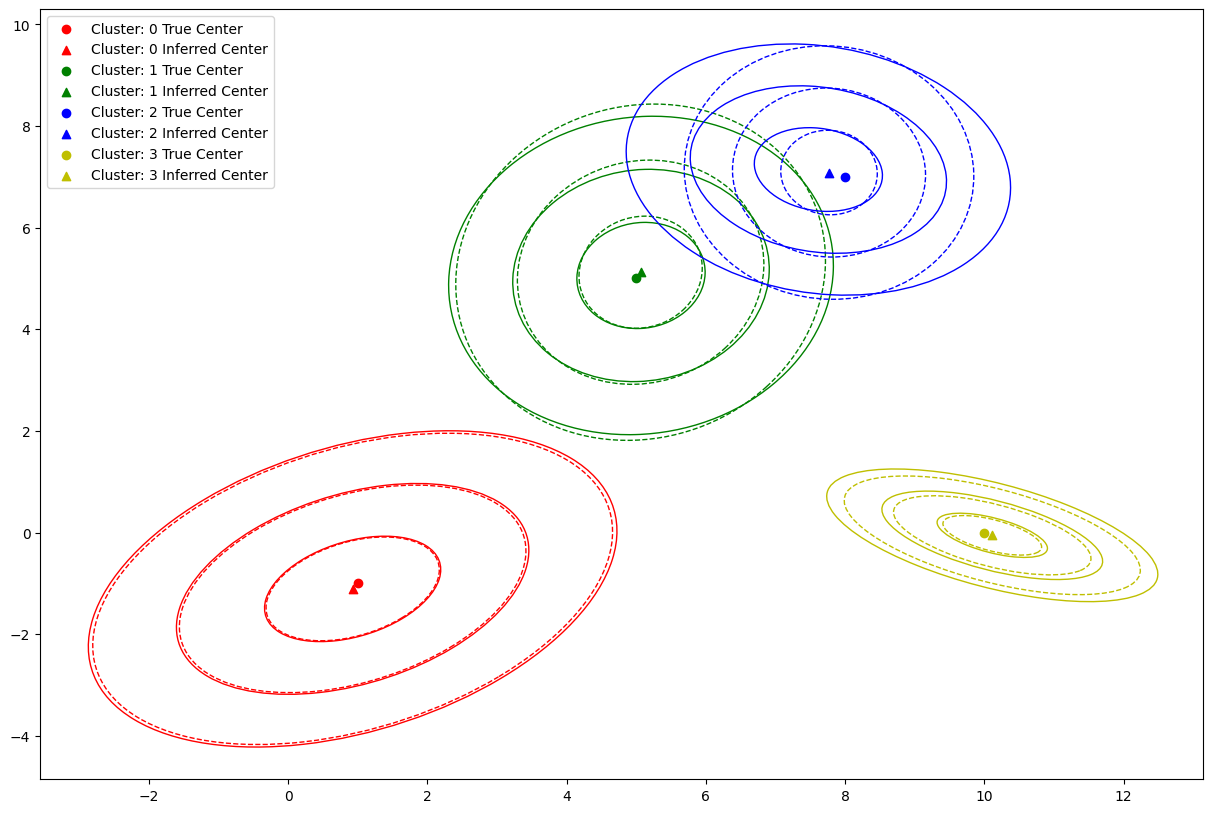

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))

colors = ["r", "g", "b", "y"]

for i, c in enumerate(colors):
    
    # Plot the centers
    plt.scatter(unknown_centers[i, 0], unknown_centers[i, 1], c=c, marker="o", label=f"Cluster: {i} True Center")
    plt.scatter(mus[i, 0], mus[i, 1], c=c, marker="^", label=f"Cluster: {i} Inferred Center")
    
    # Plot the standard deviations
    mask = y == i
    masked_points = X[mask]
    mu_x = np.mean(masked_points, axis=0)
    sigma = np.cov(masked_points[:, 0], masked_points[:, 1])
    confidence_ellipse(mu_x, sigma,  ax=axs, n_std=1, edgecolor=c, linestyle="-")
    confidence_ellipse(mu_x, sigma, ax=axs, n_std=2, edgecolor=c, linestyle="-")
    confidence_ellipse(mu_x, sigma, ax=axs, n_std=3, edgecolor=c, linestyle="-")


    confidence_ellipse(mus[i], sigmas[i],  ax=axs, n_std=1, edgecolor=c, linestyle="--")
    confidence_ellipse(mus[i], sigmas[i], ax=axs, n_std=2, edgecolor=c, linestyle="--")
    confidence_ellipse(mus[i], sigmas[i], ax=axs, n_std=3, edgecolor=c, linestyle="--")
plt.legend(loc="best")


# Followup

For more advanced concepts, please check out []()